In [1]:
import importlib
from libs import models, plots, trades, params
importlib.reload(models)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(trades)

import pandas as pd
import numpy as np
import math

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime

from tqdm import tqdm
import matplotlib.pyplot as plt   
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayDataset])


In [2]:
device               = params.device
ticker               = params.ticker
base_path            = params.save_path
look_back            = params.look_back
label_col            = params.label_col
feature_cols         = params.feature_cols
pred_threshold       = params.pred_threshold_man
regular_start        = params.regular_start
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
trailing_stop_thresh = params.trailing_stop_thresh_man

# month to inspect (YYYY-MM)
month_to_check = "2025-02"

# model path
val_rmse_str = "0.1855"   # same rmse in the filename

csv_dir: str = "./dfs training"
path_csv = f"{csv_dir}/{ticker}_test_DF.csv"

model_path = base_path / f"{ticker}_{val_rmse_str}.pth"
model_path

PosixPath('dfs training/GOOGL_0.1855.pth')

In [3]:
# Load the entire model object (architecture + weights)
model_best = torch.load(model_path, map_location=device, weights_only=False)
model_best.to(device).eval()
model_best

DualMemoryLSTM(
  (short_lstm): LSTM(5, 128, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (do_short): Dropout(p=0.3, inplace=False)
  (ln_short): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(128, 256, batch_first=True)
  (do_long): Dropout(p=0.4, inplace=False)
  (ln_long): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=256, out_features=1, bias=True)
)

In [4]:
dataset_test_path = base_path / f"{ticker}_test_ds.pt"
dataset_test = torch.load(dataset_test_path)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataset_val_path = base_path / f"{ticker}_val_ds.pt"
dataset_val = torch.load(dataset_val_path)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

dataloader_test, dataloader_val

(<torch.utils.data.dataloader.DataLoader at 0x79b82e508a70>,
 <torch.utils.data.dataloader.DataLoader at 0x79bba274bce0>)

In [5]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(dataloader_val)
test_baseline = models.naive_rmse(dataloader_test)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.38354
Test zero‐forecast baseline RMSE = 0.35328


std val: 0.23884213
std test: 0.22694588


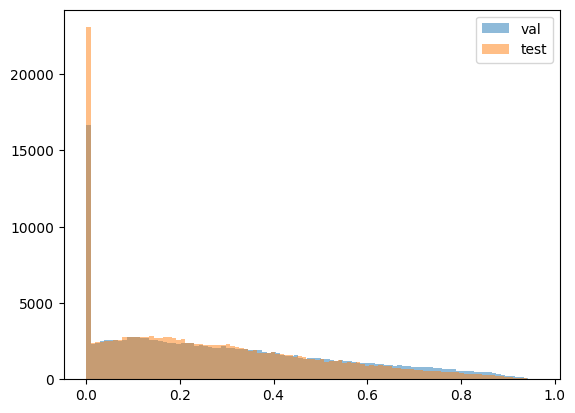

In [6]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_val])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in dataloader_test])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [7]:

def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str = "Test",
    compute_rmse: bool = True,
    collect_preds: bool = False
):
    """
    Run your LSTM over every day in `loader`, with the same reset logic
    you use in rmse_over_windows and collect_predictions, but controlled by flags:
      - compute_rmse: if True, accumulates MSE and returns RMSE
      - collect_preds: if True, gathers every window's prediction into a flat array

    Returns:
      (rmse, preds) where:
        • rmse is a float if compute_rmse else None
        • preds is a 1D np.ndarray if collect_preds else None

    You can call:
      rmse, _     = evaluate_model(model, loader, device, split_name, True, False)
      _, preds    = evaluate_model(model, loader, device, split_name, False, True)
      rmse, preds = evaluate_model(model, loader, device, split_name, True, True)
    """
    # Move model & reset its internal state
    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_wd        = None
    total_sq_error = 0.0     # for RMSE
    total_windows  = 0       # counter for windows
    all_preds      = []      # list to store per-day preds

    # Iterate exactly as in two original functions
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"{split_name}", unit="day"):
            # Unpack: xb_day, yb_day, optional raw_*, wd
            xb_day, yb_day, *_, wd = batch
            wd_val = int(wd.item())

            # reset per-day LSTM
            model.reset_short()
            # reset per-week LSTM on weekday wrap
            if prev_wd is not None and wd_val < prev_wd:
                model.reset_long()
            prev_wd = wd_val

            # pull input windows and true targets
            x    = xb_day[0].to(device)        # shape: (W, look_back, F)
            y    = yb_day.view(-1).to(device)  # shape: (W,)

            # forward pass → get last-step prediction
            out  = model(x)                    # (W, look_back, 1)
            pred = out[:, -1, 0]               # (W,)

            # accumulate RMSE stats if requested
            if compute_rmse:
                total_sq_error += (pred - y).pow(2).sum().item()
                total_windows  += y.numel()

            # collect raw preds if requested
            if collect_preds:
                all_preds.append(pred.cpu().numpy())

    # compute final RMSE
    rmse = None
    if compute_rmse:
        rmse = math.sqrt(total_sq_error / total_windows)
        print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")

    # flatten collected predictions
    preds = None
    if collect_preds:
        preds = np.concatenate(all_preds, axis=0)

    return rmse, preds


In [8]:
val_rmse, _     = evaluate_model(model_best, dataloader_val, device, split_name="Validation")
test_rmse, _     = evaluate_model(model_best, dataloader_test, device, split_name="Test")

_, preds = evaluate_model(model_best, dataloader_test, device,
                          split_name="Test",
                          compute_rmse=False, collect_preds=True)

preds.shape

Validation: 100%|██████████| 410/410 [00:03<00:00, 108.07day/s]



Validation RMSE over 160310 windows = 0.18554


Test: 100%|██████████| 422/422 [00:03<00:00, 117.03day/s]



Test RMSE over 165002 windows = 0.19826


Test: 100%|██████████| 422/422 [00:03<00:00, 116.57day/s]


(165002,)

In [9]:
df = pd.read_csv(path_csv, index_col=0, parse_dates=True)
df.sort_index(inplace=True)
df

open      high      low     close     volume  \
2023-10-12 12:30:00  141.270  141.2900  141.250  141.2900       21.0   
2023-10-12 12:31:00  141.270  141.2950  141.250  141.2750      140.0   
2023-10-12 12:32:00  141.270  141.3000  141.250  141.2600      259.0   
2023-10-12 12:33:00  141.300  141.3000  141.290  141.2900      200.0   
2023-10-12 12:34:00  141.300  141.3000  141.300  141.3000      100.0   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                          bid       ask  StrategyEarning  EarningDiff  \
2023-10-12 12:30:00  141.2476  141.3324              0.0        0.000   
2023-10-12 12:31:00  141.2326  141.3174              0.0        0.000   
2023-10-12 12:32:00  141.2176  141.3024              0.0        0.000   
2023-10-12 12:33:00  141.2476  141.3324              0.0        0.000   
2023-10-12 12:34:00  141.2576  141.3424              0.0        0.000   
...                       ...       ...              ...          ...   
2025-06-18 20:56:00  173.5129  173.6171             -1.4        1.310   
2025-06-18 20:57:00  173.3280  173.4320             -1.4        1.495   
2025-06-18 20:58:00  173.2580  173.3620             -1.4        1.565   
2025-06-18 20:59:00  173.2280  173.3320             -1.4        1.595   
2025-06-18 21:00:00  173.5576  173.6618             -1.4        1.265   

                     signal_scaled  signal_smooth  signal_action  pred_signal  \
2023-10-12 12:30:00       0.140551       0.147977              0          NaN   
2023-10-12 12:31:00       0.155070       0.140752              0          NaN   
2023-10-12 12:32:00       0.169676       0.131548              0          NaN   
2023-10-12 12:33:00       0.141822       0.125869              0          NaN   
2023-10-12 12:34:00       0.132764       0.131079              0          NaN   
...                            ...            ...            ...          ...   
2025-06-18 20:56:00       0.000000       0.000000              0     0.151977   
2025-06-18 20:57:00       0.000000       0.000000              0    -0.050134   
2025-06-18 20:58:00       0.000000       0.000000              0    -0.146714   
2025-06-18 20:59:00       0.000000       0.000000              0    -0.117812   
2025-06-18 21:00:00       0.000000       0.000000              0    -0.214465   

                     pred_action  
2023-10-12 12:30:00            0  
2023-10-12 12:31:00            0  
2023-10-12 12:32:00            0  
2023-10-12 12:33:00            0  
2023-10-12 12:34:00            0  
...                          ...  
2025-06-18 20:56:00           -1  
2025-06-18 20:57:00            0  
2025-06-18 20:58:00            0  
2025-06-18 20:59:00            0  
2025-06-18 21:00:00            0  

[215642 rows x 14 columns]

In [10]:

def add_pred_actions(
    df, preds
) -> pd.DataFrame:
    """
    1) Load full‐period minute‐bar DF.
    2) Stamp preds only on the exact rows the model saw:
         – drop first look_back bars of each day
         – keep only times inside [regular_start, regular_end)
    3) Run generate_trade_actions on each calendar‐day slice.
    4) Reassemble, persist, and return.
    """

    df["pred_signal"] = np.nan

    # 1) reconstruct all days → drop first look_back bars per day
    valid_ts = []
    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        day_df = day_df.sort_index()
        truncated = day_df.iloc[look_back:]

        # 2) **ONLY** require time ≥ regular_start_shifted (
        mask = truncated.index.time >= regular_start
        valid_ts.append(truncated.index[mask])

    valid_idx = pd.DatetimeIndex(np.concatenate([ts.values for ts in valid_ts]))

    if len(valid_idx) != len(preds):
        raise ValueError(f"{len(valid_idx)} valid slots vs {len(preds)} preds")

    # 3) stamp
    df.loc[valid_idx, "pred_signal"] = preds

    # 4) generate actions _per day_ exactly as before
    dfs = []
    for day, day_df in df.groupby(df.index.normalize(), sort=False):
        dfs.append(
            trades.generate_trade_actions(
                df                   = day_df,
                col_signal           = "pred_signal",
                col_action           = "pred_action",
                buy_threshold        = pred_threshold,
                trailing_stop_thresh = trailing_stop_thresh,
                regular_start        = regular_start
            )
        )

    df_out = pd.concat(dfs).sort_index()
    df_out.to_csv(path_csv)
    return df_out


In [11]:
df_with_preds = add_pred_actions(df, preds)
df_with_preds

open      high      low     close     volume  \
2023-10-12 12:30:00  141.270  141.2900  141.250  141.2900       21.0   
2023-10-12 12:31:00  141.270  141.2950  141.250  141.2750      140.0   
2023-10-12 12:32:00  141.270  141.3000  141.250  141.2600      259.0   
2023-10-12 12:33:00  141.300  141.3000  141.290  141.2900      200.0   
2023-10-12 12:34:00  141.300  141.3000  141.300  141.3000      100.0   
...                      ...       ...      ...       ...        ...   
2025-06-18 20:56:00  173.375  173.6771  173.215  173.5650   621199.0   
2025-06-18 20:57:00  173.565  173.5900  173.240  173.3800   624198.0   
2025-06-18 20:58:00  173.390  173.4100  173.200  173.3100   454542.0   
2025-06-18 20:59:00  173.315  173.4000  173.230  173.2800  1094746.0   
2025-06-18 21:00:00  173.300  174.0500  173.170  173.6097  7649838.0   

                          bid       ask  StrategyEarning  EarningDiff  \
2023-10-12 12:30:00  141.2476  141.3324              0.0        0.000   
2023-10-12 12:31:00  141.2326  141.3174              0.0        0.000   
2023-10-12 12:32:00  141.2176  141.3024              0.0        0.000   
2023-10-12 12:33:00  141.2476  141.3324              0.0        0.000   
2023-10-12 12:34:00  141.2576  141.3424              0.0        0.000   
...                       ...       ...              ...          ...   
2025-06-18 20:56:00  173.5129  173.6171             -1.4        1.310   
2025-06-18 20:57:00  173.3280  173.4320             -1.4        1.495   
2025-06-18 20:58:00  173.2580  173.3620             -1.4        1.565   
2025-06-18 20:59:00  173.2280  173.3320             -1.4        1.595   
2025-06-18 21:00:00  173.5576  173.6618             -1.4        1.265   

                     signal_scaled  signal_smooth  signal_action  pred_signal  \
2023-10-12 12:30:00       0.140551       0.147977              0          NaN   
2023-10-12 12:31:00       0.155070       0.140752              0          NaN   
2023-10-12 12:32:00       0.169676       0.131548              0          NaN   
2023-10-12 12:33:00       0.141822       0.125869              0          NaN   
2023-10-12 12:34:00       0.132764       0.131079              0          NaN   
...                            ...            ...            ...          ...   
2025-06-18 20:56:00       0.000000       0.000000              0     0.151977   
2025-06-18 20:57:00       0.000000       0.000000              0    -0.050134   
2025-06-18 20:58:00       0.000000       0.000000              0    -0.146714   
2025-06-18 20:59:00       0.000000       0.000000              0    -0.117812   
2025-06-18 21:00:00       0.000000       0.000000              0    -0.214465   

                     pred_action  
2023-10-12 12:30:00            0  
2023-10-12 12:31:00            0  
2023-10-12 12:32:00            0  
2023-10-12 12:33:00            0  
2023-10-12 12:34:00            0  
...                          ...  
2025-06-18 20:56:00           -1  
2025-06-18 20:57:00            0  
2025-06-18 20:58:00            0  
2025-06-18 20:59:00            0  
2025-06-18 21:00:00            0  

[215642 rows x 14 columns]

In [12]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_with_preds,         # full DF with pred_action
    col_action          = "pred_action",         # name of the discrete action column
    regular_start       = params.regular_start,  # e.g. time(9,30)
    regular_end         = params.regular_end,    # e.g. time(16,0)
    ticker              = params.ticker
)


generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...



Plotting days in 2025-02:


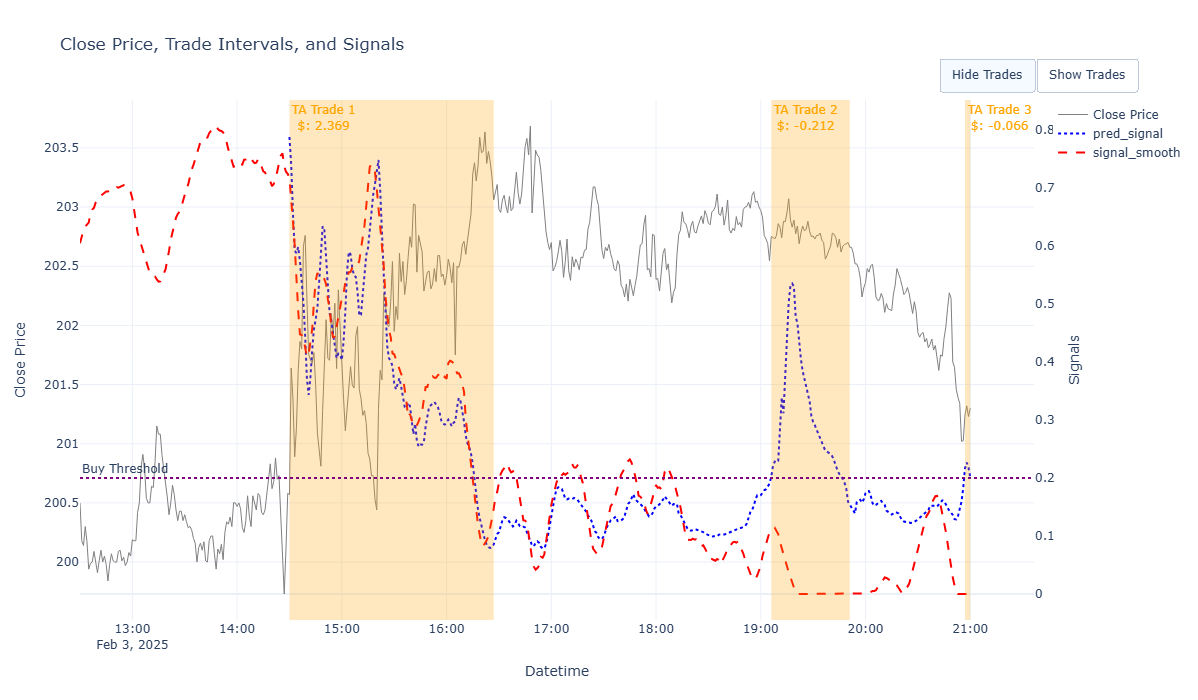


=== Performance for 2025-02-03 00:00:00 ===
Strategy Return ($): 2.022
Buy & Hold Return ($): 0.539
Trades Returns ($): [2.369, -0.212, -0.066]


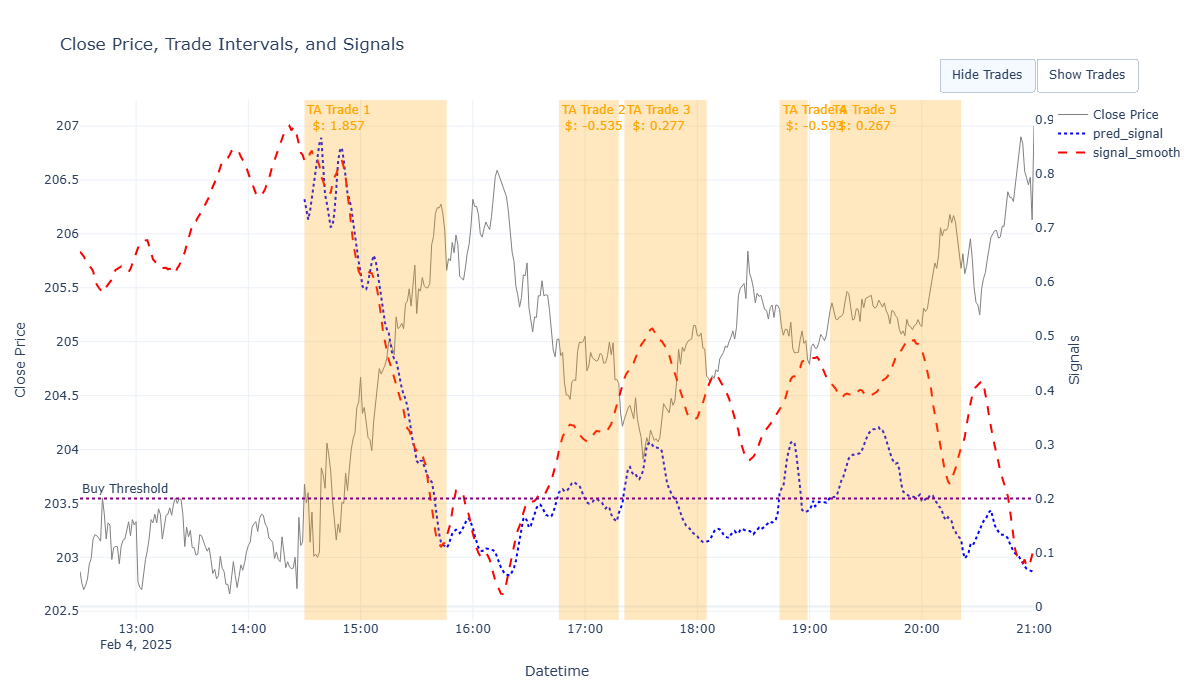


=== Performance for 2025-02-04 00:00:00 ===
Strategy Return ($): 1.274
Buy & Hold Return ($): 2.327
Trades Returns ($): [1.857, -0.535, 0.277, -0.593, 0.267]


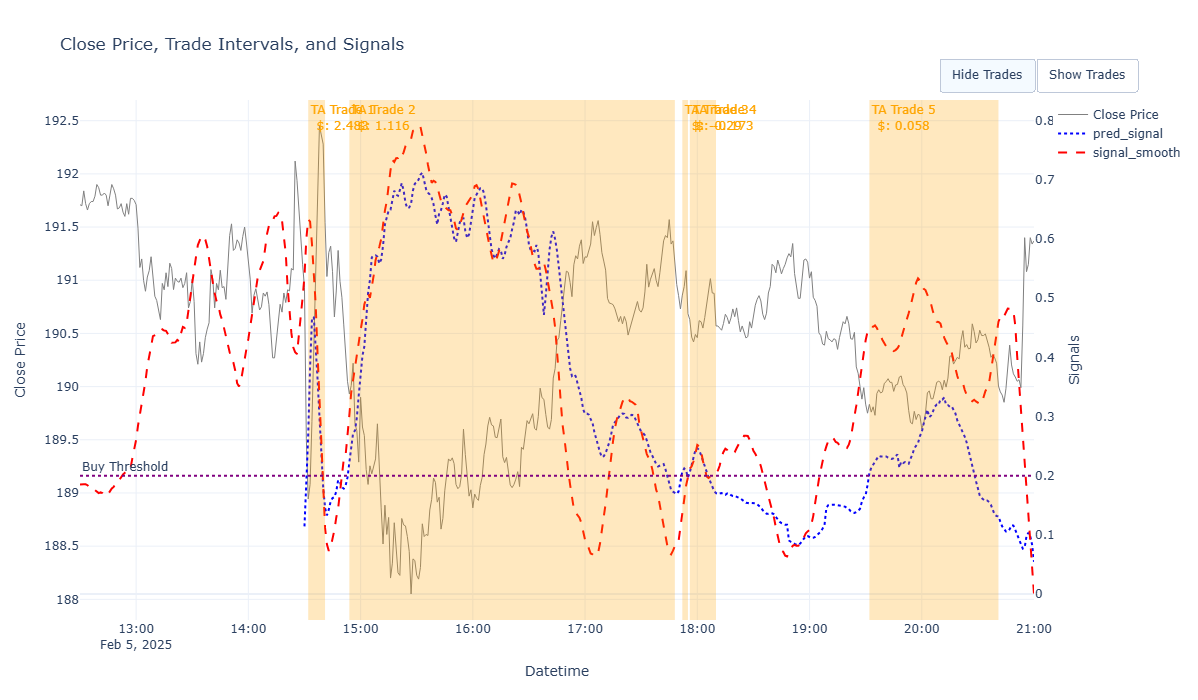


=== Performance for 2025-02-05 00:00:00 ===
Strategy Return ($): 3.194
Buy & Hold Return ($): 0.295
Trades Returns ($): [2.483, 1.116, -0.29, -0.173, 0.058]


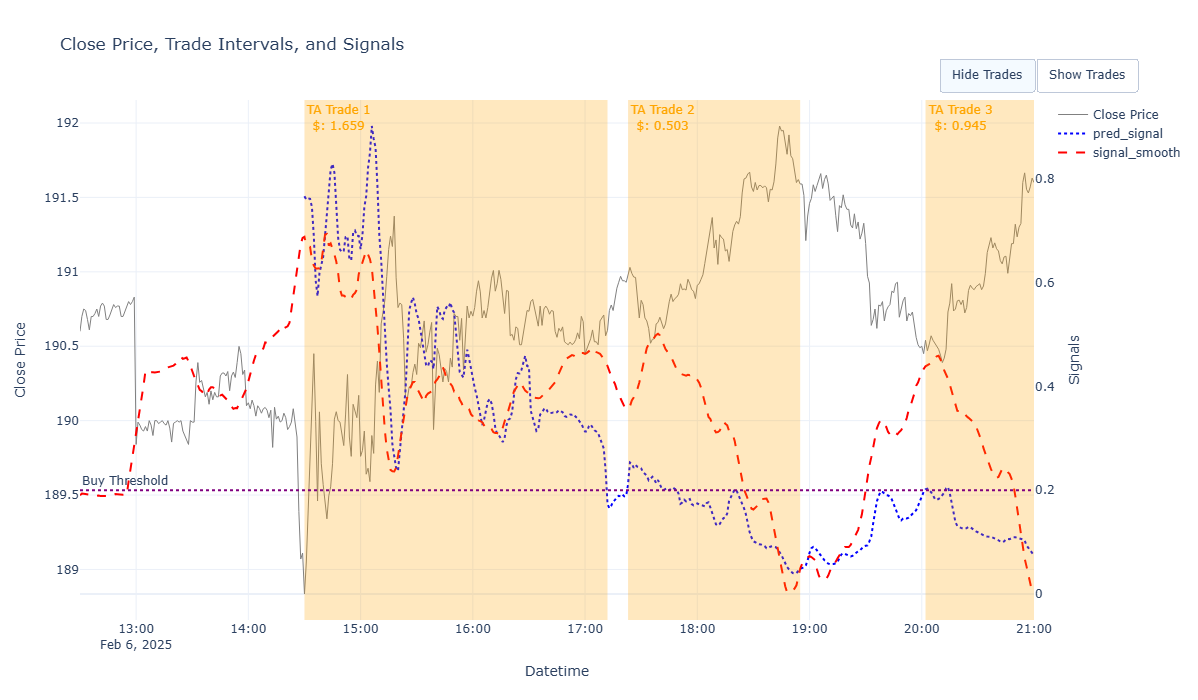


=== Performance for 2025-02-06 00:00:00 ===
Strategy Return ($): 3.137
Buy & Hold Return ($): 2.681
Trades Returns ($): [1.659, 0.503, 0.945]


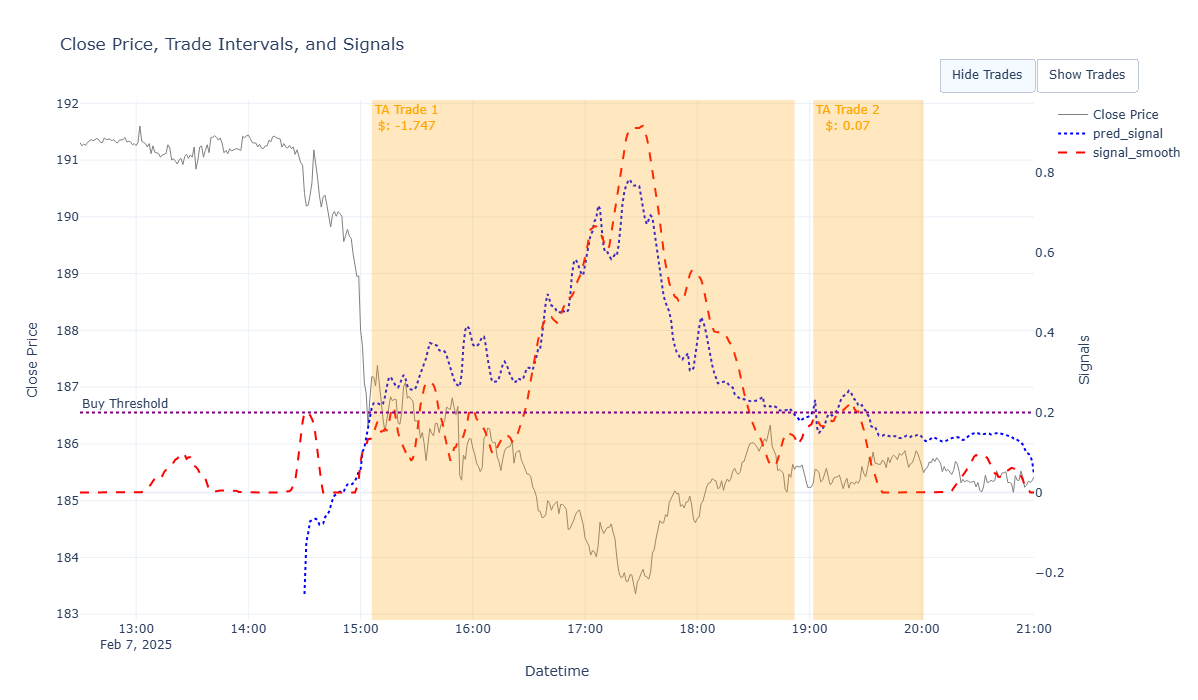


=== Performance for 2025-02-07 00:00:00 ===
Strategy Return ($): -1.677
Buy & Hold Return ($): -5.173
Trades Returns ($): [-1.747, 0.07]


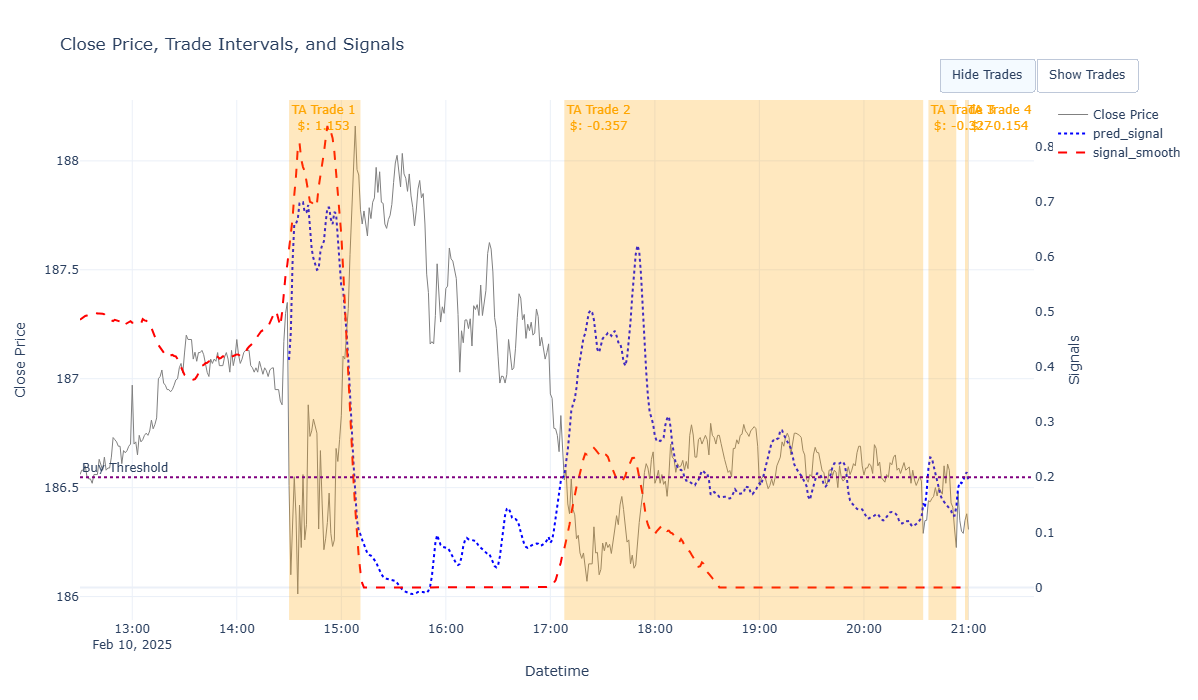


=== Performance for 2025-02-10 00:00:00 ===
Strategy Return ($): 0.387
Buy & Hold Return ($): -0.242
Trades Returns ($): [1.153, -0.357, -0.327, -0.154]


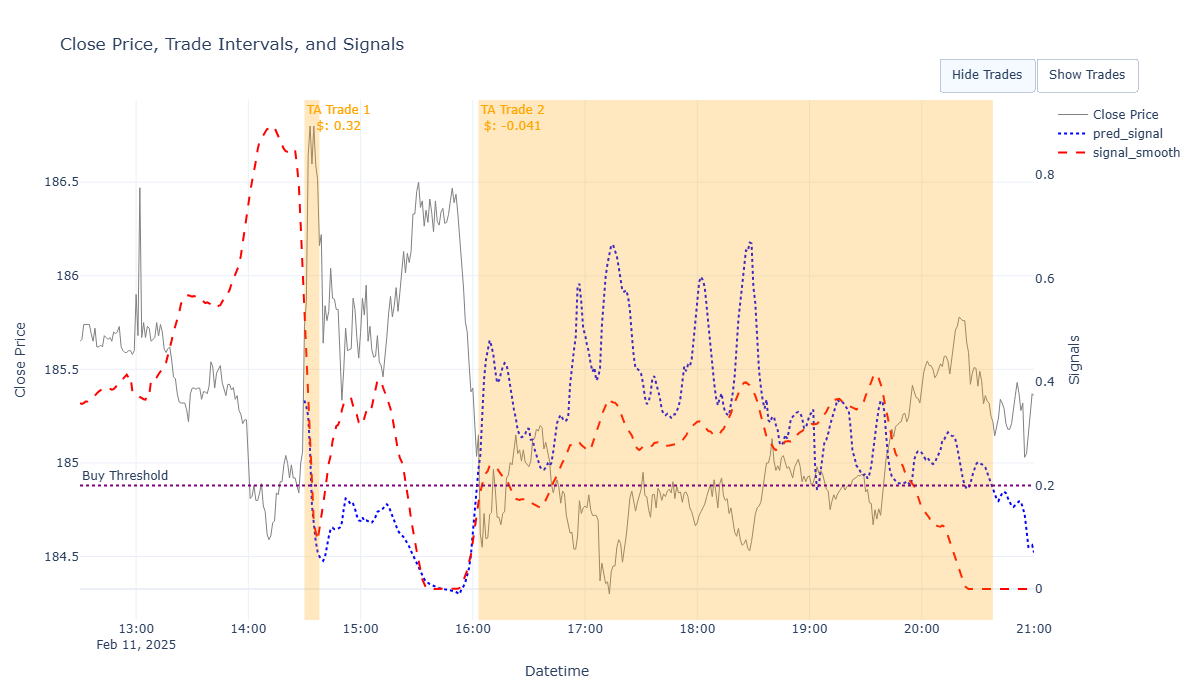


=== Performance for 2025-02-11 00:00:00 ===
Strategy Return ($): 0.278
Buy & Hold Return ($): -0.471
Trades Returns ($): [0.32, -0.041]


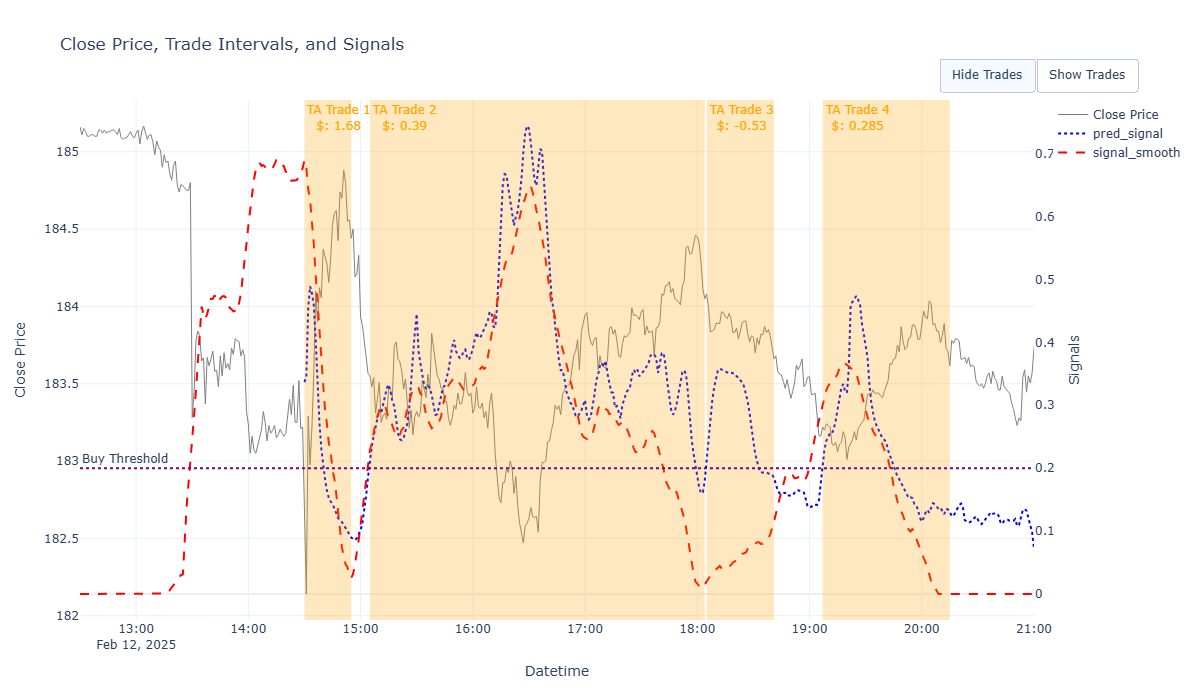


=== Performance for 2025-02-12 00:00:00 ===
Strategy Return ($): 1.825
Buy & Hold Return ($): 0.81
Trades Returns ($): [1.68, 0.39, -0.53, 0.285]


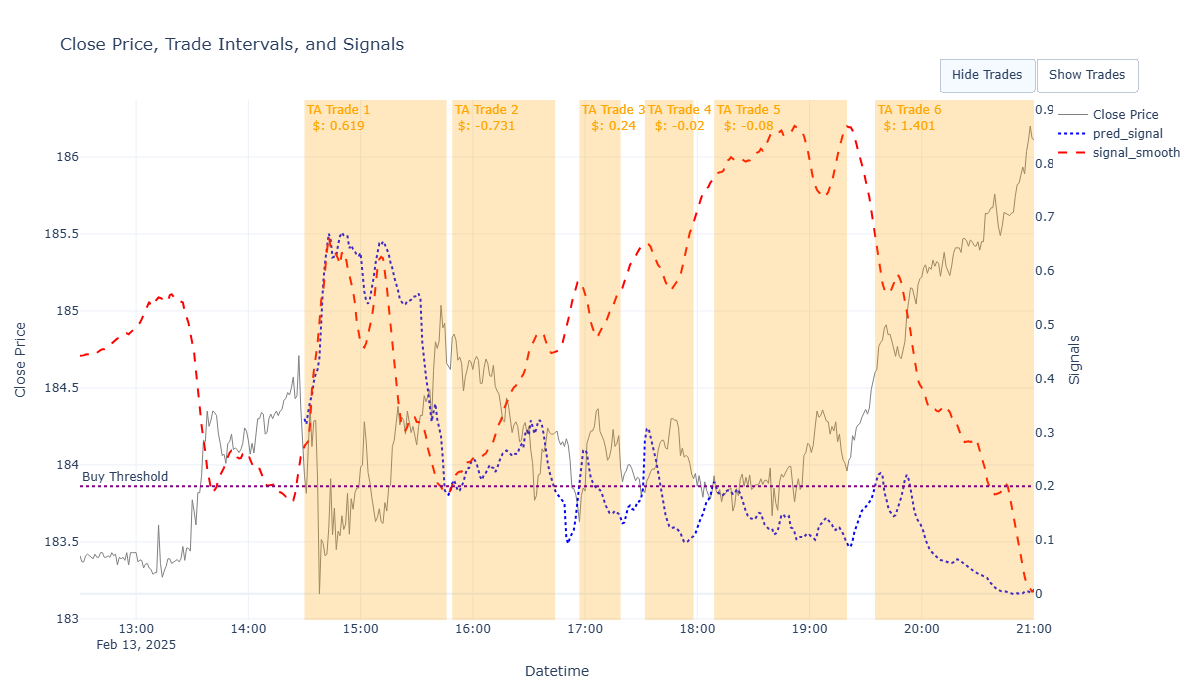


=== Performance for 2025-02-13 00:00:00 ===
Strategy Return ($): 1.436
Buy & Hold Return ($): 2.079
Trades Returns ($): [0.619, -0.731, 0.24, -0.02, -0.08, 1.401]


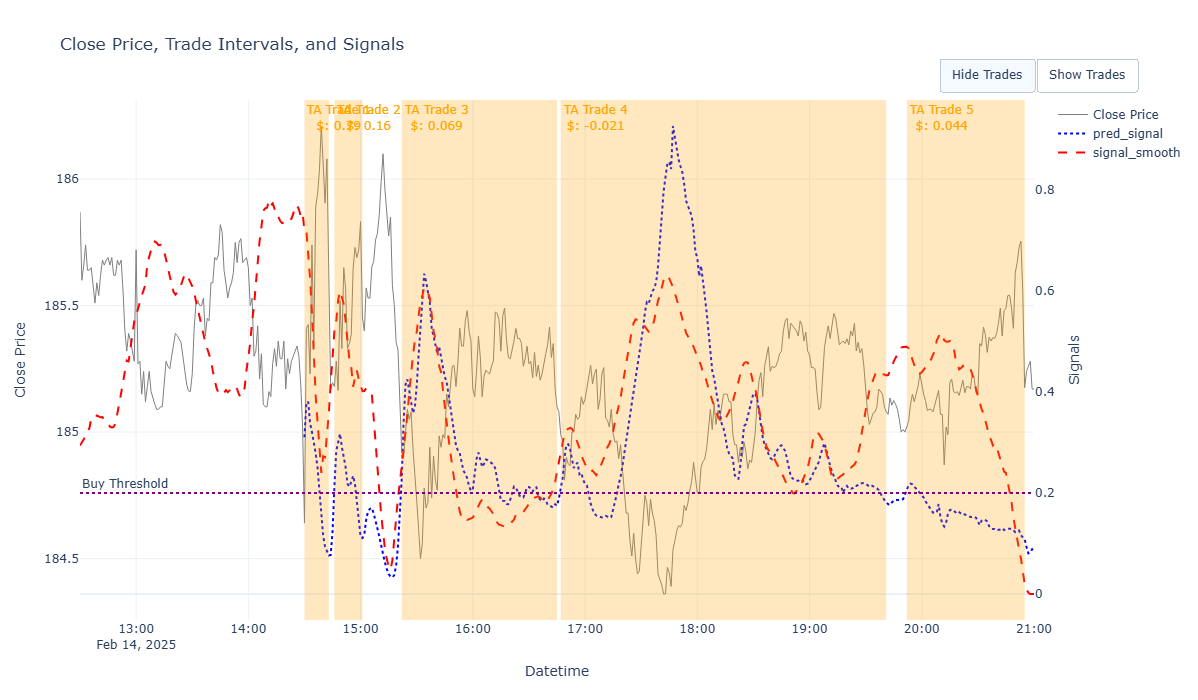


=== Performance for 2025-02-14 00:00:00 ===
Strategy Return ($): 1.042
Buy & Hold Return ($): 0.419
Trades Returns ($): [0.79, 0.16, 0.069, -0.021, 0.044]


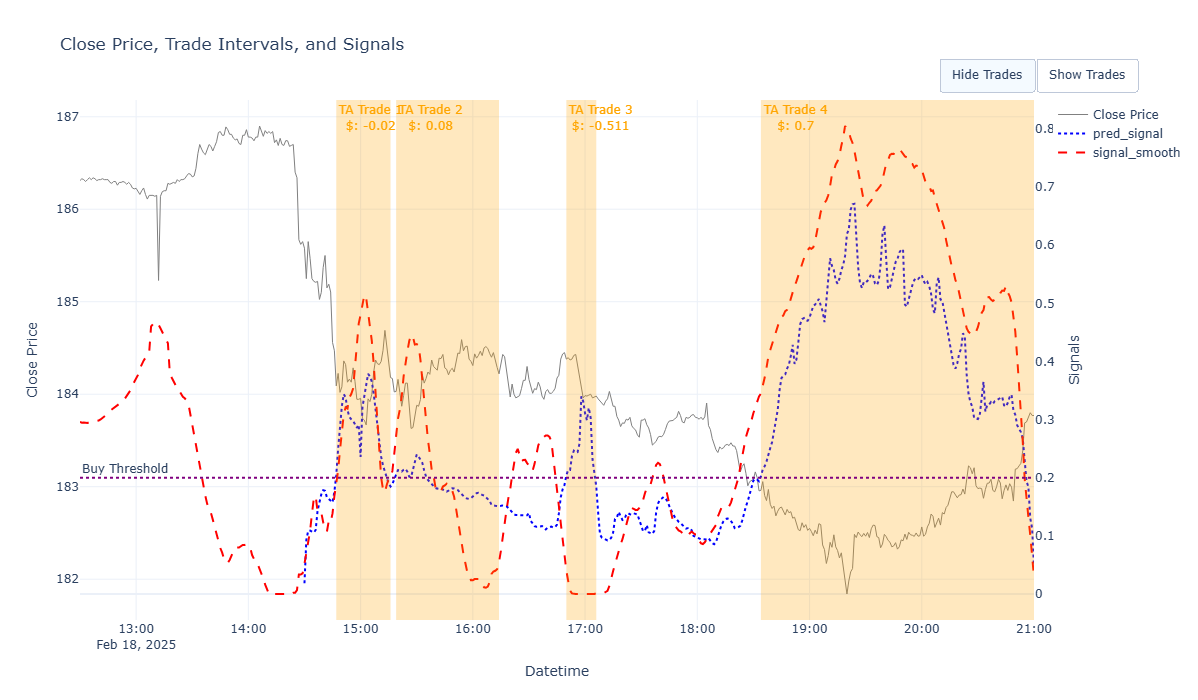


=== Performance for 2025-02-18 00:00:00 ===
Strategy Return ($): 0.249
Buy & Hold Return ($): -1.92
Trades Returns ($): [-0.02, 0.08, -0.511, 0.7]


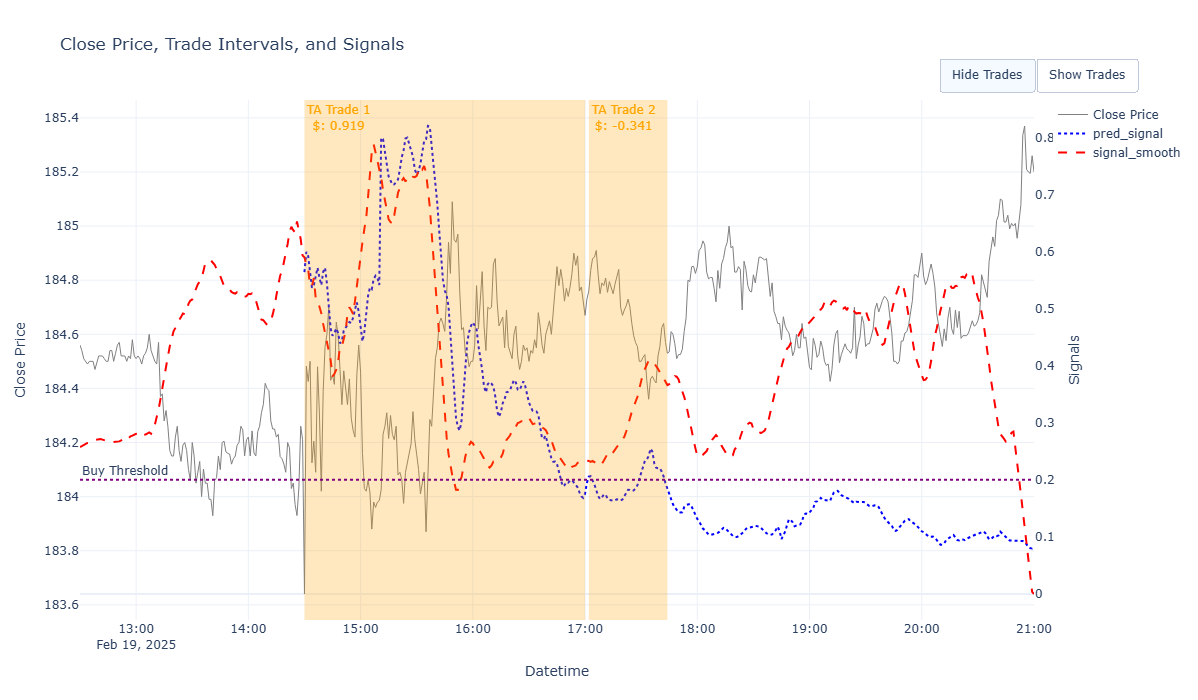


=== Performance for 2025-02-19 00:00:00 ===
Strategy Return ($): 0.579
Buy & Hold Return ($): 1.509
Trades Returns ($): [0.919, -0.341]


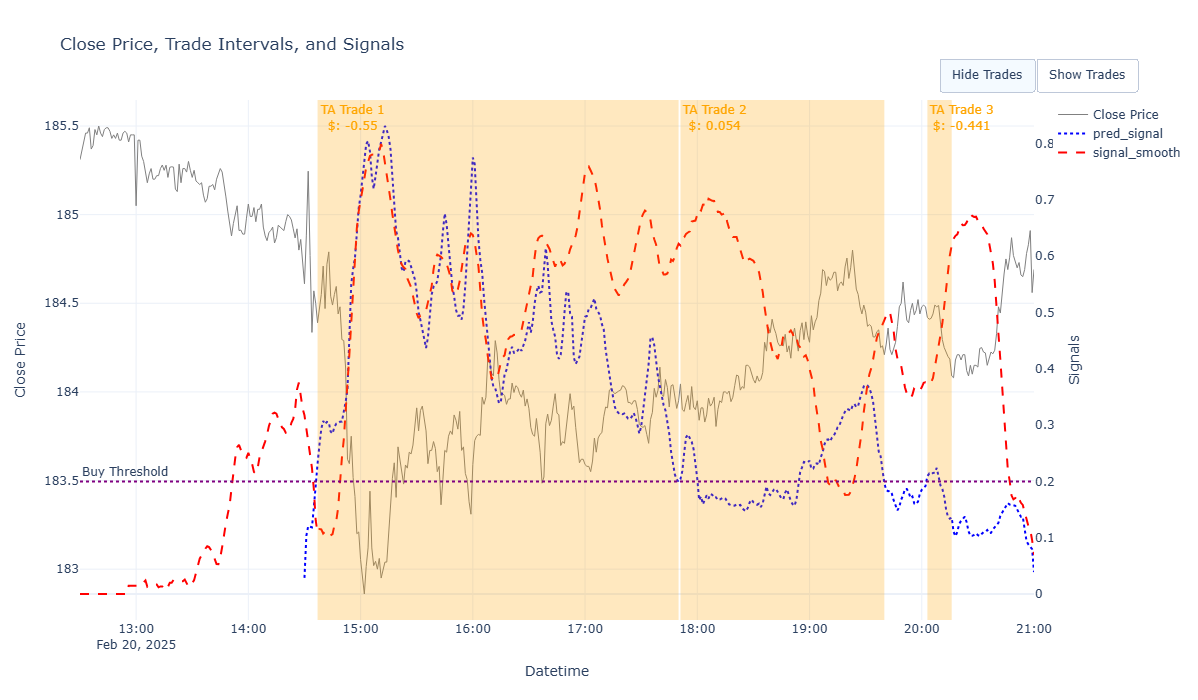


=== Performance for 2025-02-20 00:00:00 ===
Strategy Return ($): -0.937
Buy & Hold Return ($): -0.161
Trades Returns ($): [-0.55, 0.054, -0.441]


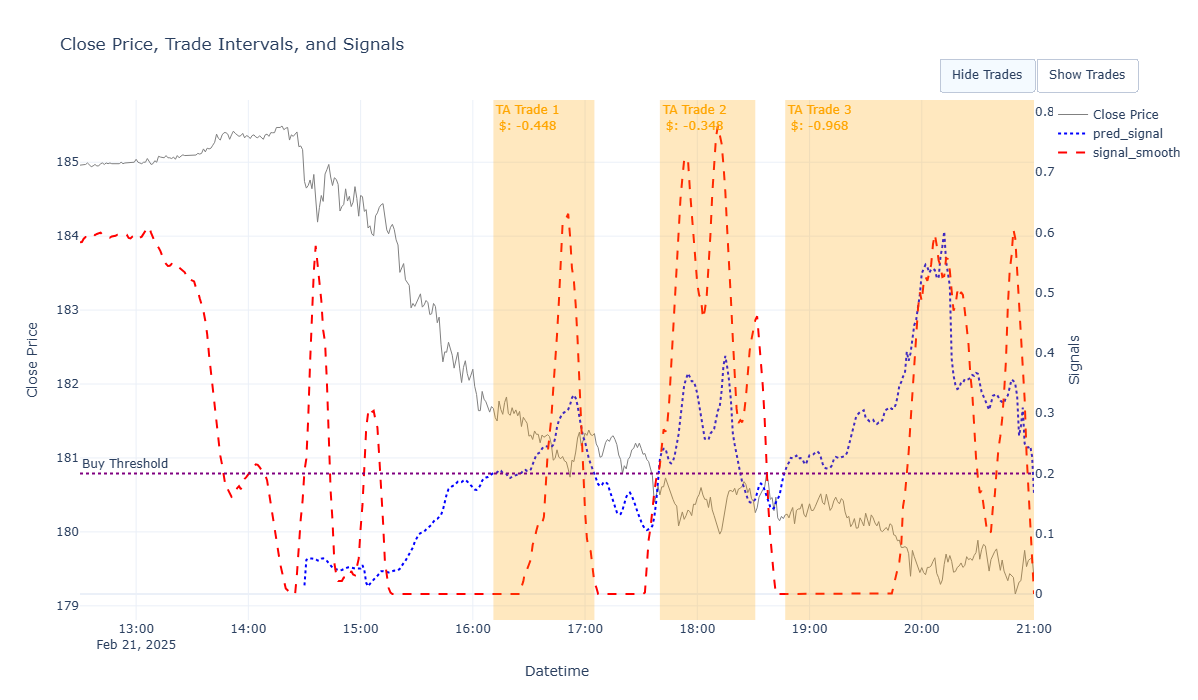


=== Performance for 2025-02-21 00:00:00 ===
Strategy Return ($): -1.475
Buy & Hold Return ($): -5.189
Trades Returns ($): [-0.448, -0.348, -0.968]


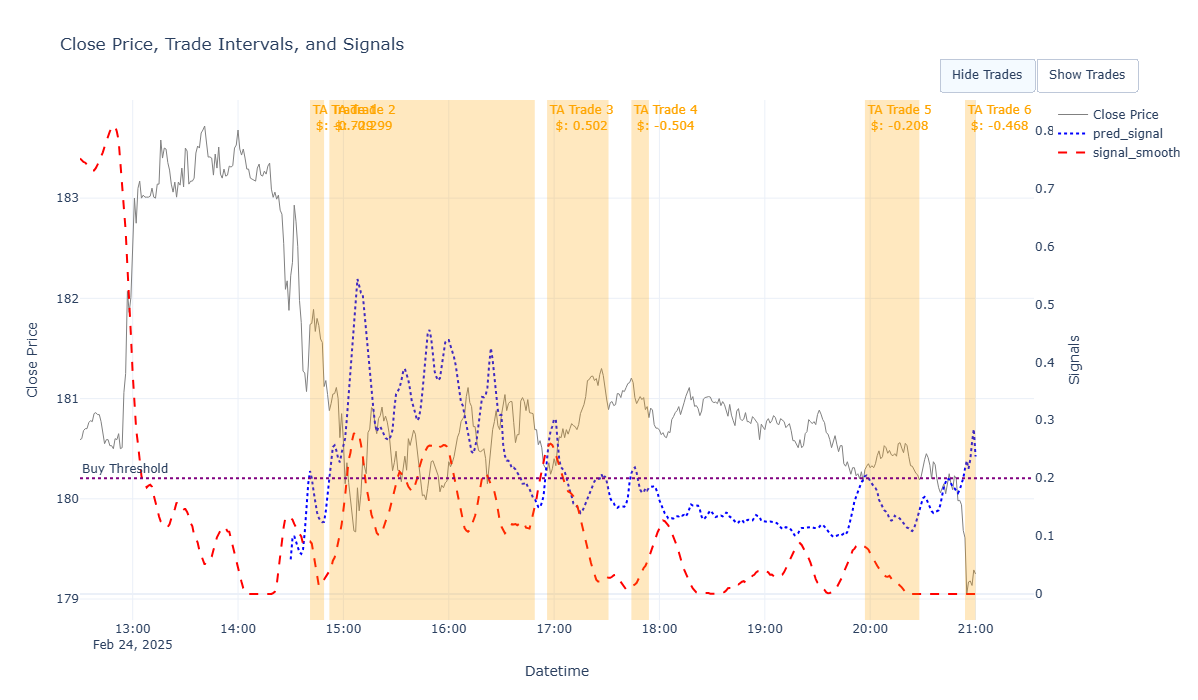


=== Performance for 2025-02-24 00:00:00 ===
Strategy Return ($): -1.665
Buy & Hold Return ($): -3.043
Trades Returns ($): [-0.729, -0.299, 0.502, -0.504, -0.208, -0.468]


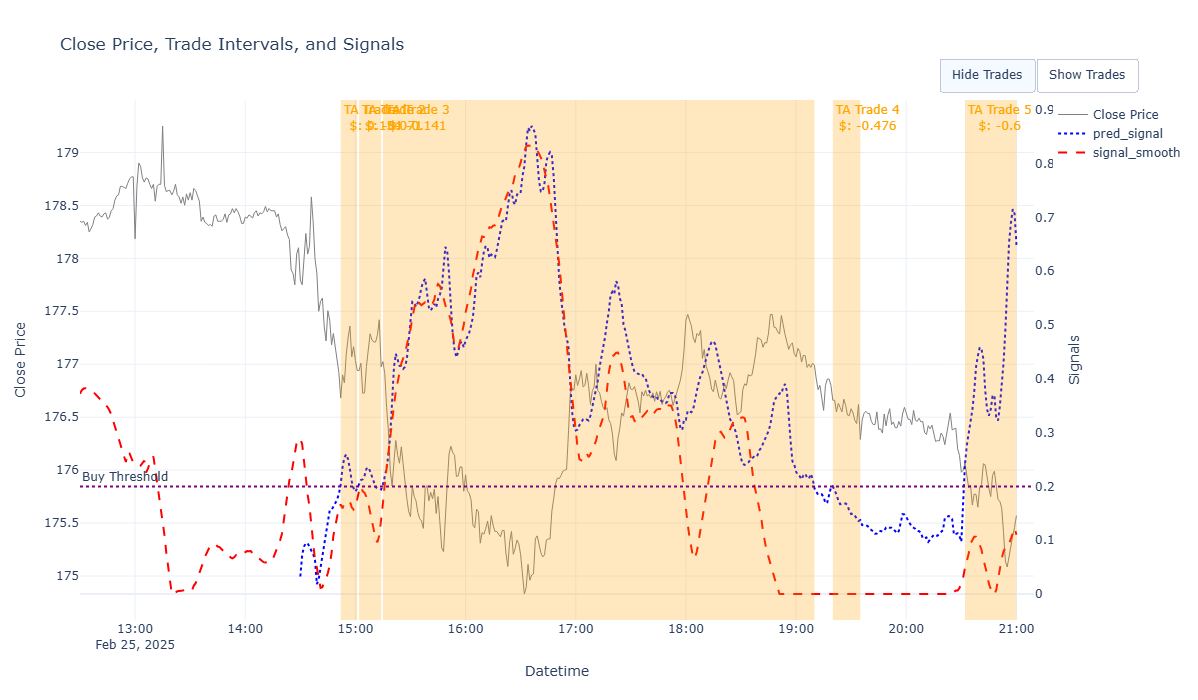


=== Performance for 2025-02-25 00:00:00 ===
Strategy Return ($): -1.244
Buy & Hold Return ($): -2.441
Trades Returns ($): [0.154, -0.071, -0.141, -0.476, -0.6]


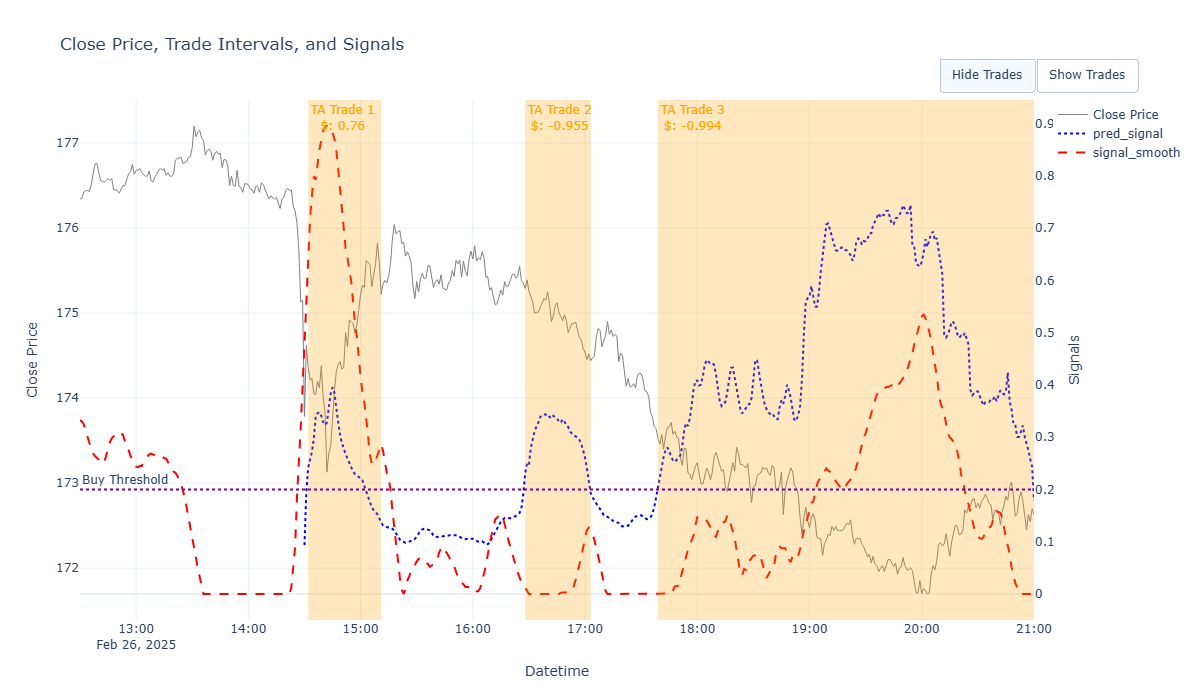


=== Performance for 2025-02-26 00:00:00 ===
Strategy Return ($): -1.119
Buy & Hold Return ($): -1.189
Trades Returns ($): [0.76, -0.955, -0.994]


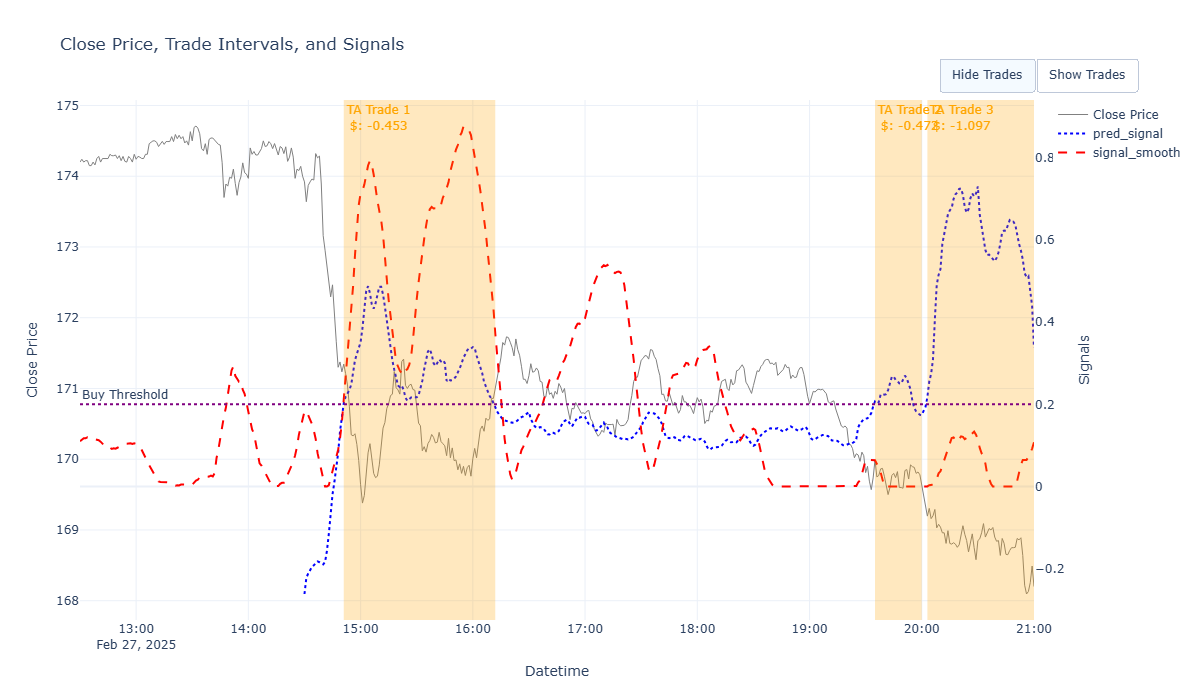


=== Performance for 2025-02-27 00:00:00 ===
Strategy Return ($): -1.732
Buy & Hold Return ($): -5.533
Trades Returns ($): [-0.453, -0.472, -1.097]


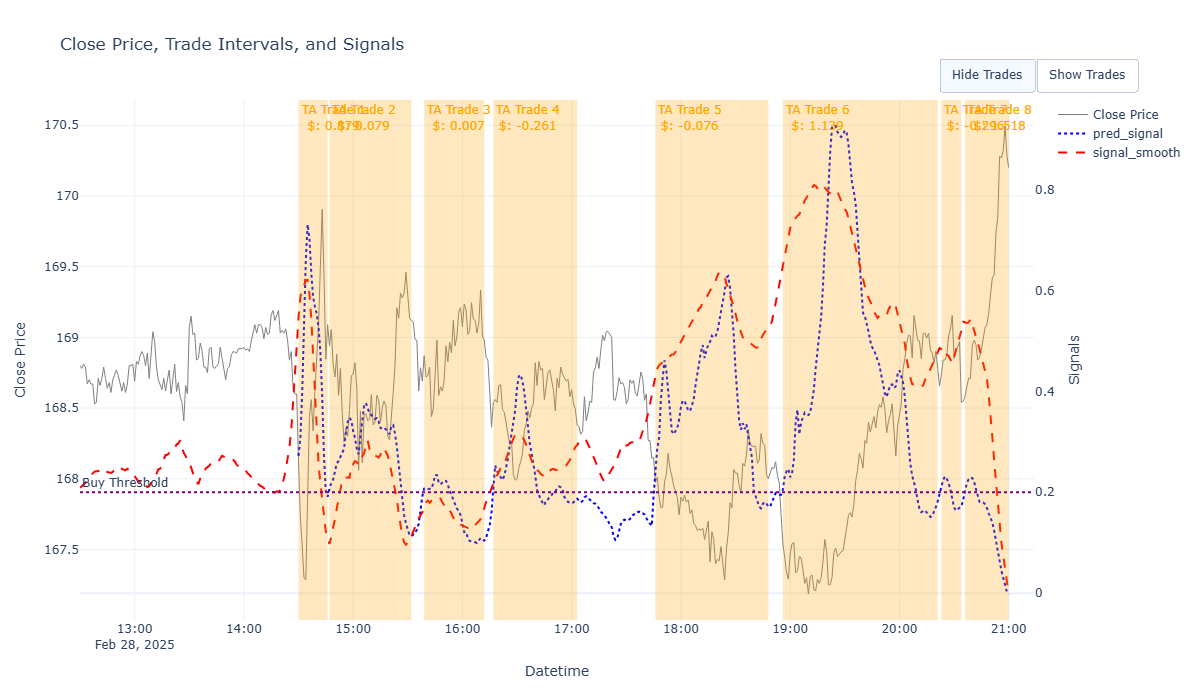


=== Performance for 2025-02-28 00:00:00 ===
Strategy Return ($): 3.079
Buy & Hold Return ($): 2.078
Trades Returns ($): [0.879, 0.079, 0.007, -0.261, -0.076, 1.139, -0.296, 1.518]

=== Overall Summary (2025-02-03 → 2025-02-28) ===
Start date price: 2025-02-03 = 201.3602
  End date price:  2025-02-28 = 170.1489
One-time buy&hold gain: -31.211

{'Buy & Hold – each day ($)': -12.625,
 'Strategy Return ($)': 8.653,
 'Trades Returns ($)': '76 trades'}

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 138.8817
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 34.676

{'Buy & Hold – each day ($)': -77.566,
 'Strategy Return ($)': 296.019,
 'Trades Returns ($)': '1505 trades'}


In [16]:

year, month = map(int, month_to_check.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {month_to_check}")
else:
    print(f"\nPlotting days in {month_to_check}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_man,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_with_preds[df_with_preds.index.to_period("M") == month_to_check]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_with_preds)
pprint(overall_summary)
